In [1]:
!wget 'https://www.dropbox.com/scl/fi/w80rzqopglpujsx2mryw2/semantic_tech_real50.csv?rlkey=ff2c7nf6n1rao0w2f2vzmnozm&st=amqrp3wk&dl=1'

--2025-04-04 10:23:52--  https://www.dropbox.com/scl/fi/w80rzqopglpujsx2mryw2/semantic_tech_real50.csv?rlkey=ff2c7nf6n1rao0w2f2vzmnozm&st=amqrp3wk&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfee49b0301acb2c21d1284bf36.dl.dropboxusercontent.com/cd/0/inline/CnJ_9V9h1Fnz59pGrWyzC0gqvOAJneEydQaosLMSP4ePchMfXSSUiqKLj5V0qFmPIN4sD8CQ8swIWEhsGWobaj5RsWaX8PftpuPQ6jjUdWnRJde30tLEaZuZabx2W3vSurDmK06i9apV8qc9VZeQ0341/file?dl=1# [following]
--2025-04-04 10:23:52--  https://ucfee49b0301acb2c21d1284bf36.dl.dropboxusercontent.com/cd/0/inline/CnJ_9V9h1Fnz59pGrWyzC0gqvOAJneEydQaosLMSP4ePchMfXSSUiqKLj5V0qFmPIN4sD8CQ8swIWEhsGWobaj5RsWaX8PftpuPQ6jjUdWnRJde30tLEaZuZabx2W3vSurDmK06i9apV8qc9VZeQ0341/file?dl=1
Resolving ucfee49b0301acb2c21d1284bf36.dl.dropboxusercontent.com (ucfee49b0301acb2c21d1284bf36.dl.dropboxu

In [ ]:
cleaned_rows = []
with open("/content/semantic_tech_real50.csv", "r", encoding="utf-8") as f:
    current_row = ''
    for line in f:
        current_row += line
        if current_row.count('"') % 2 == 0:  # line is complete if quotes are balanced
            cleaned_rows.append(current_row.strip())
            current_row = ''

# Save cleaned content to a temp file
with open("cleaned_sentiment.csv", "w", encoding="utf-8") as f:
    f.write("\n".join(cleaned_rows))


In [ ]:
import pandas as pd

df = pd.read_csv("cleaned_sentiment.csv")
print(df.head())


                                  review_title  \
0                    Reliable and travels well   
1  Samsung 4K T.V. Up-scales 1080 so very nice   
2                             Perfect solution   
3        Good 1TB Drive. SmartWare... not good   
4                      Do Not Waste Your Money   

                                         review_text    brand  sentiment  \
0  I've had one of the eGo 500GB Iomega drives no...    apple          1   
1  Bought my Samsung 65 inch this weekend and I a...  samsung          1   
2  This was the perfect solution to my predicamen...  samsung          1   
3  I would not exaggerate if I called myself a WD...   lenovo          1   
4  Wow!  I bought two of these for use in my depa...  samsung         -1   

   star_rating  
0          4.0  
1          5.0  
2          5.0  
3          4.0  
4          1.0  


In [2]:
!pip install -q  datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cu

In [ ]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# ======================
# 🔹 STEP 1: Load and clean the dataset
# ======================
def load_clean_csv(file_path):
    cleaned_rows = []
    with open(file_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader)
        for row in reader:
            if len(row) == len(header):
                cleaned_rows.append(row)
    df = pd.DataFrame(cleaned_rows, columns=header)
    return df

file_path = "/content/semantic_tech_real50.csv"
data = load_clean_csv(file_path)

# ======================
# 🔹 STEP 2: Extract relevant columns
# ======================
data = data[['review_text', 'sentiment']]
data.columns = ['text', 'label']

# Drop rows with missing values
data = data.dropna(subset=['text', 'label'])
data['text'] = data['text'].astype(str).str.strip()

# ======================
# 🔹 STEP 3: Convert labels
# ======================
# From -1, 0, 1 → shift to 0, 1, 2 for one-hot encoding
data['label'] = data['label'].astype(int) + 1
data = data[data['label'].isin([0, 1, 2])]  # ensure valid

# Optional: Check class distribution
print("Label distribution:\n", data['label'].value_counts())

# ======================
# 🔹 STEP 4: Preprocess text
# ======================
comments = data['text'].values
labels = to_categorical(data['label'].values, num_classes=3)

VOCAB_SIZE = 30000
EMBEDDING_DIM = 300
MAX_LENGTH = 200
BATCH_SIZE = 64
EPOCHS = 30

X_train, X_test, y_train, y_test = train_test_split(comments, labels, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

# ======================
# 🔹 STEP 5: Define LSTM model
# ======================
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    Bidirectional(LSTM(256, return_sequences=True, activation='tanh')),
    Dropout(0.5),
    Bidirectional(LSTM(128, activation='tanh')),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ======================
# 🔹 STEP 6: Train model
# ======================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_test_padded, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

# ======================
# 🔹 STEP 7: Evaluate model
# ======================
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f"✅ Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

model.save("lstm_sentiment_model_apple_samsung.keras")

# ======================
# 🔹 STEP 8: Predict on sample reviews
# ======================
sample_comments = [
    "The new iPhone is amazing and super fast.",
    "Samsung's battery life is terrible.",
    "It’s okay, nothing special honestly."
]

sample_seq = tokenizer.texts_to_sequences(sample_comments)
sample_pad = pad_sequences(sample_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
predictions = model.predict(sample_pad)

# Map back from class index to label: 0→negative, 1→neutral, 2→positive
label_decode = {0: "negative", 1: "neutral", 2: "positive"}
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = [label_decode[i] for i in predicted_classes]

for text, pred in zip(sample_comments, predicted_labels):
    print(f"💬 {text}\n➡️  Predicted Sentiment: {pred}\n")


Label distribution:
 label
2    22722
0    15011
1    13035
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 62s 83ms/step - accuracy: 0.5227 - loss: 0.9750 - val_accuracy: 0.6316 - val_loss: 0.8328
Epoch 2/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 80s 87ms/step - accuracy: 0.6361 - loss: 0.8137 - val_accuracy: 0.6629 - val_loss: 0.7660
Epoch 3/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - accuracy: 0.7051 - loss: 0.6873 - val_accuracy: 0.6836 - val_loss: 0.7281
Epoch 4/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 55s 86ms/step - accuracy: 0.7597 - loss: 0.5933 - val_accuracy: 0.6906 - val_loss: 0.7187
Epoch 5/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 83s 88ms/step - accuracy: 0.7919 - loss: 0.5220 - val_accuracy: 0.6867 - val_loss: 0.7614
Epoch 6/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 83s 89ms/step - accuracy: 0.8351 - loss: 0.4348 - val_accuracy: 0.6719 - val_loss: 0.7986
Epoch 7/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 81s 87ms/step - accuracy: 0.8741 - loss: 0.3495 - val_accuracy: 0.6817 - val_loss: 0.9059
Epoch 8/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 83s 88ms/step - accuracy: 0.9012 - loss: 0.2851 - 

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import csv

# ============================================================
# 🔹 WHAT THIS MODEL DOES:
# This is a BiLSTM-based sentiment classifier (like the first one),
# but with added metrics: confusion matrix + classification report.
# ============================================================

# ======================
# ✅ STEP 1: Load and clean your dataset
# ======================
def load_clean_csv(file_path):
    cleaned_rows = []
    with open(file_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader)
        for row in reader:
            if len(row) == len(header):
                cleaned_rows.append(row)
    df = pd.DataFrame(cleaned_rows, columns=header)
    return df

file_path = "/content/semantic_tech_real50.csv"
data = load_clean_csv(file_path)

# Use only the relevant columns
data = data[['review_text', 'sentiment']]
data.columns = ['text', 'label']

# Clean text and label columns
data = data.dropna(subset=['text', 'label'])
data['text'] = data['text'].astype(str).str.strip()
data['label'] = data['label'].astype(int) + 1  # Convert from -1,0,1 → 0,1,2
data = data[data['label'].isin([0, 1, 2])]

# ======================
# ✅ STEP 2: Prepare text and labels
# ======================
comments = data['text'].values
labels = to_categorical(data['label'].values, num_classes=3)

# Parameters
VOCAB_SIZE = 30000
EMBEDDING_DIM = 300
MAX_LENGTH = 200
BATCH_SIZE = 64
EPOCHS = 30

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(comments, labels, test_size=0.2, random_state=42)

# Tokenization and padding
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

# ======================
# ✅ STEP 3: Build the BiLSTM Model
# (Same architecture as previous model)
# ======================
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    Bidirectional(LSTM(256, activation='tanh', return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(128, activation='tanh')),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ======================
# ✅ STEP 4: Train the model
# ======================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_test_padded, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

# ======================
# ✅ STEP 5: Evaluate with accuracy + metrics
# ======================
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f"✅ Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Save model
model.save("lstm_sentiment_model_with_metrics.keras")

# ======================
# ✅ STEP 6: Classification Report + Confusion Matrix
# ======================
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("🔍 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

print("🔍 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ======================
# ✅ STEP 7: Run on sample reviews
# ======================
sample_comments = [
    "The Galaxy S24 is fast but heats up.",
    "iPhone 15 Pro Max is incredible!",
    "Not good, not bad, just average."
]

sample_seq = tokenizer.texts_to_sequences(sample_comments)
sample_pad = pad_sequences(sample_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

predictions = model.predict(sample_pad)
predicted_labels = np.argmax(predictions, axis=1) - 1  # back to -1, 0, 1

for text, prob, label in zip(sample_comments, predictions, predicted_labels):
    print(f"💬 {text}")
    print(f"➡️  Probabilities: {prob}")
    print(f"➡️  Predicted Label: {label}\n")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 62s 90ms/step - accuracy: 0.5289 - loss: 0.9759 - val_accuracy: 0.6547 - val_loss: 0.7812
Epoch 2/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.6641 - loss: 0.7616 - val_accuracy: 0.6768 - val_loss: 0.7375
Epoch 3/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.7194 - loss: 0.6507 - val_accuracy: 0.6526 - val_loss: 0.7778
Epoch 4/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.7771 - loss: 0.5449 - val_accuracy: 0.6960 - val_loss: 0.7017
Epoch 5/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 83s 89ms/step - accuracy: 0.8268 - loss: 0.4490 - val_accuracy: 0.6903 - val_loss: 0.8115
Epoch 6/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 82s 88ms/step - accuracy: 0.8662 - loss: 0.3623 - val_accuracy: 0.6847 - val_loss: 0.9006
Epoch 7/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 81s 87ms/step - accuracy: 0.9000 - loss: 0.2783 - val_accuracy: 0.6779 - val_loss: 1.0477
Epoch 8/30
635/635 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - accuracy: 0.9263 - loss: 0.2196 - 

In [ ]:
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# =============================================================
# 🔍 WHAT THIS DOES:
# - Adds Conv1D + GlobalMaxPooling1D before BiLSTM
# - Uses 5-fold cross-validation
# - Collects accuracy, F1-score, and classification report
# - Trains a new model from scratch for each fold
# =============================================================

# ======================
# ✅ Load and clean the dataset
# ======================
def load_clean_csv(file_path):
    cleaned_rows = []
    with open(file_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader)
        for row in reader:
            if len(row) == len(header):
                cleaned_rows.append(row)
    df = pd.DataFrame(cleaned_rows, columns=header)
    return df

file_path = "/content/semantic_tech_real50.csv"
data = load_clean_csv(file_path)

# Use relevant columns
data = data[['review_text', 'sentiment']]
data.columns = ['text', 'label']
data = data.dropna(subset=['text', 'label'])
data['text'] = data['text'].astype(str).str.strip()
data['label'] = data['label'].astype(int) + 1  # Shift labels: -1,0,1 → 0,1,2
data = data[data['label'].isin([0, 1, 2])]

# ======================
# ✅ Set parameters and tokenize text
# ======================
VOCAB_SIZE = 30000
EMBEDDING_DIM = 300
MAX_LENGTH = 200
BATCH_SIZE = 64

texts = data['text'].values
labels = data['label'].values

# Tokenizer should be fit once on all data
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# ======================
# ✅ K-Fold Cross-Validation setup
# ======================
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_f1_scores = []
fold_reports = []

# ======================
# 🔄 Perform K-Fold loop
# ======================
for fold, (train_index, val_index) in enumerate(kf.split(data)):
    print(f"\n🔁 Fold {fold + 1}/{kf.get_n_splits()}")

    # Split data for this fold
    train_data = data.iloc[train_index]
    val_data = data.iloc[val_index]

    X_train_fold = train_data['text']
    y_train_fold = train_data['label']
    X_val_fold = val_data['text']
    y_val_fold = val_data['label']

    # Tokenize and pad
    X_train_seq = tokenizer.texts_to_sequences(X_train_fold)
    X_val_seq = tokenizer.texts_to_sequences(X_val_fold)
    X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
    X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

    # Convert labels to one-hot
    y_train_categorical = to_categorical(y_train_fold, num_classes=3)
    y_val_categorical = to_categorical(y_val_fold, num_classes=3)

    # ======================
    # ✅ Define the model (Conv1D + BiLSTM + GlobalMaxPooling)
    # ======================
    model = Sequential([
        Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
        Conv1D(128, 5, activation='relu'),                          # ✅ New layer: extract local patterns
        Bidirectional(LSTM(128, return_sequences=True)),            # Bidirectional LSTM layer
        GlobalMaxPooling1D(),                                       # ✅ New layer: reduces sequence to vector
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')                              # Softmax for 3-class classification
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    model.fit(
        X_train_padded, y_train_categorical,
        epochs=5,                        # 🔁 Fewer epochs to keep training light per fold
        batch_size=BATCH_SIZE,
        verbose=0                        # 🤫 Silent training to avoid clutter
    )

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val_padded, y_val_categorical, verbose=0)
    print(f"✅ Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    # Predict and compute metrics
    y_val_pred_probs = model.predict(X_val_padded)
    y_val_pred = np.argmax(y_val_pred_probs, axis=1)
    y_val_true = y_val_fold.values.astype(int)

    fold_f1 = f1_score(y_val_true, y_val_pred, average='weighted')
    print(f"📊 F1-Score: {fold_f1:.4f}")

    # Store metrics
    fold_accuracies.append(val_accuracy)
    fold_f1_scores.append(fold_f1)
    fold_reports.append(classification_report(
        y_val_true, y_val_pred,
        target_names=['Negative', 'Neutral', 'Positive'],
        output_dict=True
    ))

# ======================
# ✅ Final summary across all folds
# ======================
print("\n📈 Cross-Validation Summary:")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Mean F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")



🔁 Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


✅ Validation Loss: 0.9633, Accuracy: 0.6833
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
📊 F1-Score: 0.6824

🔁 Fold 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


✅ Validation Loss: 0.9363, Accuracy: 0.6760
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
📊 F1-Score: 0.6798

🔁 Fold 3/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


✅ Validation Loss: 0.9287, Accuracy: 0.6894
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
📊 F1-Score: 0.6910

🔁 Fold 4/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


✅ Validation Loss: 0.9950, Accuracy: 0.6731
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
📊 F1-Score: 0.6707

🔁 Fold 5/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


✅ Validation Loss: 0.8940, Accuracy: 0.6867
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
📊 F1-Score: 0.6860

📈 Cross-Validation Summary:
Mean Accuracy: 0.6817 ± 0.0062
Mean F1-Score: 0.6820 ± 0.0068


Here's your GRU + Stratified K-Fold code again, now with inline comments that explain exactly how it works, and how it's different from the previous LSTM and Conv1D+LSTM models.

In [ ]:
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# ======================
# ✅ Load and clean the dataset
# ======================
def load_clean_csv(file_path):
    cleaned_rows = []
    with open(file_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader)
        for row in reader:
            if len(row) == len(header):
                cleaned_rows.append(row)
    df = pd.DataFrame(cleaned_rows, columns=header)
    return df

file_path = "/content/semantic_tech_real50.csv"
data = load_clean_csv(file_path)

# Take relevant columns
data = data[['review_text', 'sentiment']]
data.columns = ['text', 'label']
data = data.dropna(subset=['text', 'label'])
data['text'] = data['text'].astype(str).str.strip()
data['label'] = data['label'].astype(int) + 1  # from (-1,0,1) → (0,1,2)
data = data[data['label'].isin([0, 1, 2])]

# ======================
# ✅ Parameters :))
# ======================
VOCAB_SIZE = 30000
EMBEDDING_DIM = 300
MAX_LENGTH = 200
BATCH_SIZE = 64
EPOCHS = 15  # More training for GRU :))
LEARNING_RATE = 0.0001  # Smaller learning rate = more stable :))

# ======================
# ✅ Prepare data and tokenize
# ======================
comments = data['text'].values
labels = to_categorical(data['label'].values, num_classes=3)  # One-hot :))
y_classes = np.argmax(labels, axis=1)  # Back to class labels for stratified split :))

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(comments)  # Only fit once :))

# ======================
# ✅ Class weights (for imbalance) :))
# ======================
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_classes), y=y_classes)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# ======================
# ✅ Stratified K-Fold setup :))
# ======================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies, fold_f1_scores = [], []

# ======================
# 🔁 Start fold loop :))
# ======================
for fold, (train_index, val_index) in enumerate(skf.split(comments, y_classes)):
    print(f"\n📁 Fold {fold + 1}/5")

    # Split comments and labels
    X_train_fold, X_val_fold = comments[train_index], comments[val_index]
    y_train_fold, y_val_fold = labels[train_index], labels[val_index]

    # Tokenize and pad sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train_fold)
    X_val_seq = tokenizer.texts_to_sequences(X_val_fold)
    X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
    X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')

    # ======================
    # ✅ Build the GRU model for this fold :))
    # ======================
    model = Sequential([
        Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
        Bidirectional(GRU(64, activation='tanh', return_sequences=True)),  # Smaller GRU for stability :))
        Dropout(0.6),  # Strong regularization :))
        GRU(32, activation='tanh'),
        Dropout(0.6),
        Dense(32, activation='relu'),
        Dropout(0.6),
        Dense(3, activation='softmax')  # Softmax for multi-class :))
    ])

    model.compile(
        optimizer='adam',  # You can swap in Adam(lr=LEARNING_RATE) if needed
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # ======================
    # ✅ Train the model :))
    # ======================
    model.fit(
        X_train_padded, y_train_fold,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weights,  # handle imbalanced classes :))
        verbose=1
    )

    # ======================
    # ✅ Evaluate and collect results :))
    # ======================
    val_loss, val_accuracy = model.evaluate(X_val_padded, y_val_fold, verbose=1)
    y_val_pred_probs = model.predict(X_val_padded)
    y_val_pred = np.argmax(y_val_pred_probs, axis=1)
    y_val_true = np.argmax(y_val_fold, axis=1)

    f1 = f1_score(y_val_true, y_val_pred, average='weighted')
    print(f"📊 Fold {fold + 1}: Accuracy = {val_accuracy:.4f}, F1 = {f1:.4f}")

    fold_accuracies.append(val_accuracy)
    fold_f1_scores.append(f1)

# ======================
# ✅ Final cross-validation results summary :))
# ======================
print("\n✅ Stratified K-Fold Summary:")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Mean F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")


Class Weights: {0: np.float64(1.127351053671752), 1: np.float64(1.2982483058432426), 2: np.float64(0.7447701200011736)}

📁 Fold 1/5
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


635/635 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.3442 - loss: 1.1006
Epoch 2/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.4141 - loss: 1.0902
Epoch 3/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.4645 - loss: 1.0751
Epoch 4/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.4890 - loss: 1.0500
Epoch 5/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.5403 - loss: 0.9878
Epoch 6/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.7096 - loss: 0.7400
Epoch 7/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.7875 - loss: 0.5856
Epoch 8/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8442 - loss: 0.4638
Epoch 9/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8845 - loss: 0.3669
Epoch 10/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9160 - loss: 0.2895
Epoch 11/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9371 - loss: 0.2288
Epoch 12/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


635/635 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.3313 - loss: 1.1012
Epoch 2/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.3872 - loss: 1.0961
Epoch 3/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.4484 - loss: 1.0833
Epoch 4/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.4791 - loss: 1.0614
Epoch 5/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.5555 - loss: 0.9838
Epoch 6/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.7196 - loss: 0.7252
Epoch 7/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8017 - loss: 0.5602
Epoch 8/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8596 - loss: 0.4396
Epoch 9/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.8997 - loss: 0.3254
Epoch 10/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.9313 - loss: 0.2459
Epoch 11/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.9476 - loss: 0.1936
Epoch 12/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


635/635 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.3395 - loss: 1.1041
Epoch 2/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.3556 - loss: 1.0967
Epoch 3/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.4228 - loss: 1.0847
Epoch 4/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.4792 - loss: 1.0590
Epoch 5/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.5125 - loss: 1.0161
Epoch 6/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5349 - loss: 0.9607
Epoch 7/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.6595 - loss: 0.8271
Epoch 8/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.7643 - loss: 0.6224
Epoch 9/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8268 - loss: 0.4820
Epoch 10/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8689 - loss: 0.3899
Epoch 11/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.9064 - loss: 0.2943
Epoch 12/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


635/635 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.3551 - loss: 1.0998
Epoch 2/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.3960 - loss: 1.0939
Epoch 3/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.4560 - loss: 1.0719
Epoch 4/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.4992 - loss: 1.0347
Epoch 5/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.5282 - loss: 0.9872
Epoch 6/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.6693 - loss: 0.8216
Epoch 7/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.7720 - loss: 0.6143
Epoch 8/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8413 - loss: 0.4695
Epoch 9/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8866 - loss: 0.3487
Epoch 10/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9178 - loss: 0.2700
Epoch 11/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9424 - loss: 0.2017
Epoch 12/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


635/635 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.3476 - loss: 1.1010
Epoch 2/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.4096 - loss: 1.0895
Epoch 3/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.4425 - loss: 1.0788
Epoch 4/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.4988 - loss: 1.0471
Epoch 5/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.6755 - loss: 0.8146
Epoch 6/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.7622 - loss: 0.6364
Epoch 7/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8291 - loss: 0.4995
Epoch 8/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8824 - loss: 0.3875
Epoch 9/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9184 - loss: 0.2881
Epoch 10/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9357 - loss: 0.2352
Epoch 11/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.9533 - loss: 0.1787
Epoch 12/15
635/635 ━━━━━━━━━━━━━━━━━━━━ 

herererererererererererererrererer*✅* GRU Model with Pre-trained GloVe Embeddings + Stratified K-Fold


In [ ]:
!pip uninstall -y numpy scipy gensim
!pip install --upgrade numpy scipy tensorflow scikit-learn


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.14.1
Uninstalling scipy-1.14.1:
  Successfully uninstalled scipy-1.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstall

In [ ]:
import os
os.kill(os.getpid(), 9)  # Force kernel restart


In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.26.4


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# ======================
# ✅ 1. Load and clean your dataset
# ======================
def load_clean_csv(file_path):
    cleaned_rows = []
    with open(file_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader)
        for row in reader:
            if len(row) == len(header):
                cleaned_rows.append(row)
    return pd.DataFrame(cleaned_rows, columns=header)

file_path = "/content/semantic_tech_real50.csv"
data = load_clean_csv(file_path)

# Use the relevant columns
data = data[['review_text', 'sentiment']]
data.columns = ['text', 'label']
data = data.dropna()
data['text'] = data['text'].astype(str).str.strip()
data['label'] = data['label'].astype(int) + 1  # Shift from -1,0,1 → 0,1,2

# ======================
# ✅ 2. Tokenization
# ======================
VOCAB_SIZE = 30000
EMBEDDING_DIM = 300
MAX_LENGTH = 200
BATCH_SIZE = 64
EPOCHS = 10

comments = data['text'].values
labels = to_categorical(data['label'].values, num_classes=3)
y_classes = np.argmax(labels, axis=1)

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(comments)

# ======================
# ✅ 3. Load GloVe embeddings manually
# Download from: https://nlp.stanford.edu/data/glove.6B.zip → use glove.6B.300d.txt
# ======================
def load_glove_embeddings(file_path, tokenizer, vocab_size=30000, embedding_dim=300):
    embeddings_index = {}
    with open(file_path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = load_glove_embeddings("glove.6B.300d.txt", tokenizer)

# ======================
# ✅ 4. Stratified K-Fold + Model Training
# ======================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies, fold_f1_scores = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(comments, y_classes)):
    print(f"\n📁 Fold {fold + 1}/5")

    X_train, X_val = comments[train_idx], comments[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_val_seq = tokenizer.texts_to_sequences(X_val)

    X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post')
    X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LENGTH, padding='post')

    # ======================
    # ✅ GRU Model using Pre-trained GloVe embeddings (trainable=False)
    # ======================
    model = Sequential([
        Embedding(
            VOCAB_SIZE, EMBEDDING_DIM,
            embeddings_initializer=Constant(embedding_matrix),
            input_length=MAX_LENGTH,
            trainable=False  # ❄️ GloVe frozen (not fine-tuned)
        ),
        Bidirectional(GRU(64, return_sequences=True, activation='tanh')),
        Dropout(0.5),
        GRU(32, activation='tanh'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 sentiment classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train
    model.fit(X_train_pad, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

    # Evaluate
    val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=1)
    print(f"✅ Fold {fold + 1} - Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.4f}")

    y_val_probs = model.predict(X_val_pad)
    y_val_pred = np.argmax(y_val_probs, axis=1)
    y_val_true = np.argmax(y_val, axis=1)

    f1 = f1_score(y_val_true, y_val_pred, average='weighted')
    fold_accuracies.append(val_accuracy)
    fold_f1_scores.append(f1)
    print(f"📊 Fold {fold + 1} - F1-Score: {f1:.4f}")

# ======================
# ✅ 5. Final Results Summary
# ======================
print("\n📈 Final GloVe GRU Model Results:")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Mean F1-Score: {np.mean(fold_f1_scores):.4f} ± {np.std(fold_f1_scores):.4f}")



📁 Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.4420 - loss: 1.0807
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - accuracy: 0.4672 - loss: 1.0564
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4458 - loss: 1.0690
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.5849 - loss: 0.8795
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.6576 - loss: 0.7564
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6961 - loss: 0.6973
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.7192 - loss: 0.6549
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.7337 - loss: 0.6167
Epoch 9/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7564 - loss: 0.5773
Epoch 10/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.7653 - loss: 0.5538
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7125 - loss: 0.6671
✅ Fold 1 - Loss: 0.6726 | Accuracy: 0.7115


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


635/635 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.4381 - loss: 1.0816
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.4652 - loss: 1.0571
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5049 - loss: 1.0268
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5525 - loss: 0.9758
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5920 - loss: 0.9149
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.6455 - loss: 0.7855
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6839 - loss: 0.7193
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.7126 - loss: 0.6603
Epoch 9/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.7288 - loss: 0.6311
Epoch 10/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7478 - loss: 0.5993
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7028 - loss: 0.6893
✅ Fold 2 - Loss: 0.6871 | Accuracy: 0.7023
318/318 ━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


635/635 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.4415 - loss: 1.0803
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.4648 - loss: 1.0568
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.4608 - loss: 1.0558
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5517 - loss: 0.9727
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6383 - loss: 0.7983
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6707 - loss: 0.7384
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6989 - loss: 0.6811
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7262 - loss: 0.6400
Epoch 9/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.7419 - loss: 0.6043
Epoch 10/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7571 - loss: 0.5793
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7180 - loss: 0.6515
✅ Fold 3 - Loss: 0.6596 | Accuracy: 0.7151
318/318 ━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


635/635 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.4327 - loss: 1.0795
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.4533 - loss: 1.0617
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.4675 - loss: 1.0566
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.4633 - loss: 1.0392
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.5411 - loss: 0.9457
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6579 - loss: 0.7579
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.6913 - loss: 0.6972
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.7145 - loss: 0.6557
Epoch 9/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7326 - loss: 0.6214
Epoch 10/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.7474 - loss: 0.5925
318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7111 - loss: 0.6555
✅ Fold 4 - Loss: 0.6657 | Accuracy: 0.7104
318/318 ━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


635/635 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.4385 - loss: 1.0782
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.4607 - loss: 1.0597
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.4891 - loss: 1.0350
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.5079 - loss: 0.9840
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.6305 - loss: 0.8046
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6630 - loss: 0.7533
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6824 - loss: 0.7175
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7025 - loss: 0.6817
Epoch 9/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.7169 - loss: 0.6574
Epoch 10/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.7345 - loss: 0.6236
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6974 - loss: 0.6860
✅ Fold 5 - Loss: 0.6746 | Accuracy: 0.7027
318/318 ━━━

In [3]:
!wget 'https://nlp.stanford.edu/data/glove.6B.zip'

--2025-04-04 10:25:17--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-04 10:25:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.00MB/s    in 2m 39s  

2025-04-04 10:27:57 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [4]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [5]:
# ONLY if you need them
!pip install scikit-learn


This code is a hybrid approach that combines:

✅ Stratified Train-Test Split (for final evaluation)

✅ Stratified K-Fold Cross-Validation (for robust training)

✅ Bidirectional LSTM model with early stopping

✅ Basic label balance checks and predictions

Let me annotate it with clear comments (inside the code) and summarize its differences from the previous ones at the end 👇

In [6]:
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# ======================
# ✅ Load & clean the dataset ;))
# ======================
def load_clean_csv(file_path):
    cleaned_rows = []
    with open(file_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader)
        for row in reader:
            if len(row) == len(header):
                cleaned_rows.append(row)
    return pd.DataFrame(cleaned_rows, columns=header)

data = load_clean_csv("/content/semantic_tech_real50.csv")
data = data[['review_text', 'sentiment']]
data.columns = ['text', 'label']
data = data.dropna()
data['text'] = data['text'].astype(str).str.strip()
data['label'] = data['label'].astype(int) + 1  # (-1,0,1) → (0,1,2)

# ======================
# ✅ Set parameters ;))
# ======================
VOCAB_SIZE = 30000
EMBEDDING_DIM = 300
MAX_LENGTH = 200
BATCH_SIZE = 64
EPOCHS = 30

# ======================
# ✅ Prepare labels and input
# ======================
comments = data['text'].values
labels = to_categorical(data['label'].values, num_classes=3)

# ======================
# ✅ Stratified Train-Test Split ;))
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    comments,
    labels,
    test_size=0.2,
    stratify=np.argmax(labels, axis=1),
    random_state=42
)

# ======================
# ✅ Tokenizer & Padding ;))
# ======================
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post')

# ======================
# ✅ Early Stopping ;))
# ======================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ======================
# ✅ Stratified K-Fold Training (on train set only)
# ======================
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1

for train_idx, val_idx in kfold.split(X_train_padded, np.argmax(y_train, axis=1)):
    print(f"\n📁 Training Fold {fold_no}/5")

    # ✅ New model for each fold (important!)
    model = Sequential([
        Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
        Bidirectional(LSTM(256, activation='tanh', return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(128, activation='tanh')),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # ✅ Train on current fold
    history = model.fit(
        X_train_padded[train_idx], y_train[train_idx],
        validation_data=(X_train_padded[val_idx], y_train[val_idx]),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=1
    )

    fold_no += 1

# ======================
# ✅ Final Evaluation on Test Set ;))
# ======================
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f"\n🧪 Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# ======================
# ✅ Save the final model
# ======================
model.save("lstm_yelp_sentiment_model_crossval.keras")

# ======================
# ✅ Predict on sample inputs ;))
# ======================
sample_comments = [
    "I love this phone. Battery life is amazing!",
    "Worst customer service I've ever had.",
    "It’s just okay. Nothing special."
]

sample_seq = tokenizer.texts_to_sequences(sample_comments)
sample_pad = pad_sequences(sample_seq, maxlen=MAX_LENGTH, padding='post')
predictions = model.predict(sample_pad)

print("Predictions (probabilities):", predictions)
predicted_labels = np.argmax(predictions, axis=1) - 1  # shift back → (-1, 0, 1)
print("Predicted Sentiment Labels:", predicted_labels)



📁 Training Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.5034 - loss: 1.0086 - val_accuracy: 0.5371 - val_loss: 0.9638
Epoch 2/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 78s 89ms/step - accuracy: 0.5368 - loss: 0.9570 - val_accuracy: 0.5620 - val_loss: 0.9001
Epoch 3/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 81s 88ms/step - accuracy: 0.5830 - loss: 0.8788 - val_accuracy: 0.4711 - val_loss: 0.9991
Epoch 4/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.5812 - loss: 0.8530 - val_accuracy: 0.6455 - val_loss: 0.7693
Epoch 5/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - accuracy: 0.6816 - loss: 0.6919 - val_accuracy: 0.6599 - val_loss: 0.7577
Epoch 6/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step - accuracy: 0.7262 - loss: 0.6089 - val_accuracy: 0.6541 - val_loss: 0.7914
Epoch 7/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - accuracy: 0.7651 - loss: 0.5583 - val_accuracy: 0.6532 - val_loss: 0.7714
Epoch 8/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.8075 - loss: 0.4858 - 

we are herer , do it tommorroe

✅ Final Version: Attention LSTM with Yelp Sentiment Dataset
python
Copy
Edit


In [7]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Attention, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# ======================
# ✅ 1. Load and clean your dataset
# ======================
def load_clean_csv(file_path):
    cleaned_rows = []
    with open(file_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader)
        for row in reader:
            if len(row) == len(header):
                cleaned_rows.append(row)
    return pd.DataFrame(cleaned_rows, columns=header)

df = load_clean_csv("/content/semantic_tech_real50.csv")
df = df[['review_text', 'sentiment']]
df.columns = ['text', 'label']
df = df.dropna()
df['text'] = df['text'].astype(str).str.strip()
df['label'] = df['label'].astype(int)

# ======================
# ✅ 2. Train/val/test split before CV
# ======================
train_val_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# ======================
# ✅ 3. Prepare tokenizer and sequences
# ======================
VOCAB_SIZE = 30000
EMBEDDING_DIM = 300
MAX_LENGTH = 200
BATCH_SIZE = 64
EPOCHS = 30

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_val_df['text'])

def prepare_sequences(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

X = prepare_sequences(train_val_df['text'])
y = train_val_df['label'].astype(int).values + 1  # shift (-1,0,1) → (0,1,2)
y_cat = to_categorical(y, num_classes=3)

# ======================
# ✅ 4. Compute class weights
# ======================
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_val_df['label']),
    y=train_val_df['label']
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}
print("Class Weights:", class_weights_dict)

# ======================
# ✅ 5. Define the model (with Attention)
# ======================
def create_attention_lstm_model():
    inputs = Input(shape=(MAX_LENGTH,))
    x = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH)(inputs)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    attention = Attention()([x, x])
    x = Concatenate()([x, attention])
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ======================
# ✅ 6. Stratified K-Fold Cross-Validation
# ======================
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
results = []

for train_idx, val_idx in kfold.split(X, y):
    print(f"\n📁 Training Fold {fold_no}/5")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]

    model = create_attention_lstm_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
    print(f"✅ Fold {fold_no}: Val Loss = {val_loss:.4f}, Accuracy = {val_accuracy:.4f}")
    results.append((val_loss, val_accuracy))
    fold_no += 1

# ======================
# ✅ 7. Final Evaluation on Held-Out Test Set
# ======================
X_test = prepare_sequences(test_df['text'])
y_test = to_categorical(test_df['label'].astype(int).values + 1, num_classes=3)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🧪 Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# ======================
# ✅ 8. Classification Report
# ======================
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) - 1  # shift back to original labels
y_true = test_df['label'].astype(int).values

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# ======================
# ✅ 9. Save the final model
# ======================
model.save("attention_lstm_yelp_sentiment.keras")


Class Weights: {0: np.float64(1.127321175784828), 1: np.float64(1.298235519754507), 2: np.float64(0.744787368652693)}

📁 Training Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 38s 66ms/step - accuracy: 0.4975 - loss: 0.9836 - val_accuracy: 0.6877 - val_loss: 0.7135
Epoch 2/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.7353 - loss: 0.6666 - val_accuracy: 0.7049 - val_loss: 0.6885
Epoch 3/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.8066 - loss: 0.5131 - val_accuracy: 0.6754 - val_loss: 0.7654
Epoch 4/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8719 - loss: 0.3714 - val_accuracy: 0.6735 - val_loss: 0.9218
Epoch 5/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.9158 - loss: 0.2423 - val_accuracy: 0.6664 - val_loss: 1.1164
Epoch 6/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.9453 - loss: 0.1674 - val_accuracy: 0.6594 - val_loss: 1.5112
Epoch 7/30
508/508 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.9647 - loss: 0.1118 - val_accuracy: 0.6570 - val_loss: 1.6090
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7077 - loss: 0.6767
✅ Fold 1: Val 

This code is very similar to the previous Attention-LSTM setup, but now uses pre-trained GloVe embeddings (like you asked earlier). Let's walk through what makes it different, and then I'll give you the fully compatible version for your Apple/Samsung Yelp dataset

In [ ]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Attention, Concatenate
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# ======================
# ✅ Load and clean your dataset
# ======================
def load_clean_csv(file_path):
    cleaned_rows = []
    with open(file_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader)
        for row in reader:
            if len(row) == len(header):
                cleaned_rows.append(row)
    return pd.DataFrame(cleaned_rows, columns=header)

df = load_clean_csv("/content/semantic_tech_real50.csv")
df = df[['review_text', 'sentiment']]
df.columns = ['text', 'label']
df = df.dropna()
df['text'] = df['text'].astype(str).str.strip()
df['label'] = df['label'].astype(int)

# ======================
# ✅ Set model parameters
# ======================
VOCAB_SIZE = 30000
EMBEDDING_DIM = 300
MAX_LENGTH = 200
BATCH_SIZE = 64
EPOCHS = 15
GLOVE_PATH = "glove.6B.300d.txt"  # Make sure this file is uploaded

# ======================
# ✅ Tokenizer & sequences
# ======================
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

def prepare_sequences(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

X = prepare_sequences(df['text'])
y = df['label'].values + 1  # Shift -1/0/1 → 0/1/2
y_cat = to_categorical(y, num_classes=3)

# ======================
# ✅ Load GloVe embeddings manually
# ======================
def load_glove_embeddings(glove_path, embedding_dim, tokenizer, vocab_size):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefficients = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefficients

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = load_glove_embeddings(GLOVE_PATH, EMBEDDING_DIM, tokenizer, VOCAB_SIZE)

# ======================
# ✅ Compute class weights
# ======================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=df['label']
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

# ======================
# ✅ Define the Attention-LSTM model with GloVe
# ======================
def create_robust_model():
    inputs = Input(shape=(MAX_LENGTH,))
    embedding_layer = Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=MAX_LENGTH,
        trainable=False  # ❄️ Keep GloVe frozen
    )(inputs)

    x = Bidirectional(LSTM(256, return_sequences=True))(embedding_layer)
    attention = Attention()([x, x])
    x = Concatenate()([x, attention])
    x = Bidirectional(LSTM(128))(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ======================
# ✅ Train/Test Split + Model Training
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y, random_state=42
)

model = create_robust_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

# ======================
# ✅ Final Test Evaluation
# ======================
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🧪 Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# ======================
# ✅ Classification Report
# ======================
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) - 1  # Back to -1/0/1
y_true = np.argmax(y_test, axis=1) - 1

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# ======================
# ✅ Save the Model
# ======================
model.save("attention_lstm_glove_yelp.keras")


Class Weights: {0: np.float64(0.6783881596715822), 1: np.float64(1.6397702049875964), 2: np.float64(1.0916123424598)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.4184 - loss: 1.0870 - val_accuracy: 0.6458 - val_loss: 0.8419
Epoch 2/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.6447 - loss: 0.8478 - val_accuracy: 0.6378 - val_loss: 0.8631
Epoch 3/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.6884 - loss: 0.7710 - val_accuracy: 0.6935 - val_loss: 0.7096
Epoch 4/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - accuracy: 0.7238 - loss: 0.7003 - val_accuracy: 0.6716 - val_loss: 0.7262
Epoch 5/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.7476 - loss: 0.6604 - val_accuracy: 0.6935 - val_loss: 0.7327
Epoch 6/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.7609 - loss: 0.6038 - val_accuracy: 0.7085 - val_loss: 0.6848
Epoch 7/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.7742 - loss: 0.5590 - val_accuracy: 0.6517 - val_loss: 0.8008
Epoch 8/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.8199 - loss: 0

Solution Strategy:
We'll combine the most effective improvements into a single version:

✅ Use GloVe embeddings (pretrained)
✅ Use Bidirectional LSTM + Attention
✅ Apply Focal Loss (to focus on hard-to-classify Neutral examples)
✅ Use Stratified Train-Test Split
✅ Include Confusion Matrix + Report to track Neutral behavior

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 69s 112ms/step - accuracy: 0.4787 - loss: 0.1122 - val_accuracy: 0.6356 - val_loss: 0.0832
Epoch 2/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 76s 104ms/step - accuracy: 0.6356 - loss: 0.0861 - val_accuracy: 0.6787 - val_loss: 0.0734
Epoch 3/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.6810 - loss: 0.0740 - val_accuracy: 0.6849 - val_loss: 0.0708
Epoch 4/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.7019 - loss: 0.0680 - val_accuracy: 0.6940 - val_loss: 0.0700
Epoch 5/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.7270 - loss: 0.0595 - val_accuracy: 0.7083 - val_loss: 0.0679
Epoch 6/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.7459 - loss: 0.0533 - val_accuracy: 0.6800 - val_loss: 0.0779
Epoch 7/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - accuracy: 0.7572 - loss: 0.0484 - val_accuracy: 0.7075 - val_loss: 0.0769
Epoch 8/20
572/572 ━━━━━━━━━━━━━━━━━━━━ 59s 103ms/step - accuracy: 0.7841 - loss: 0

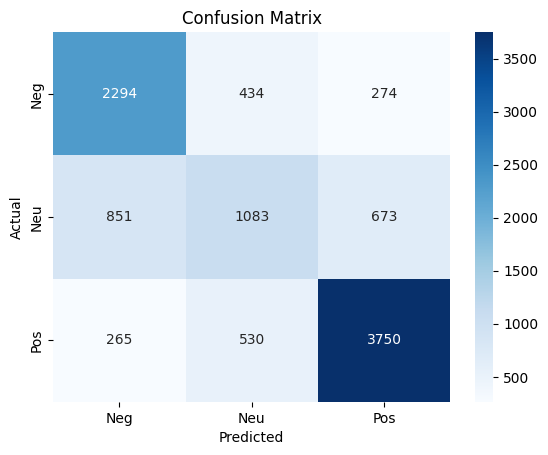

In [8]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Attention, Concatenate
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import seaborn as sns
import matplotlib.pyplot as plt

# ======================
# ✅ 1. Load and clean your dataset
# ======================
def load_clean_csv(file_path):
    cleaned_rows = []
    with open(file_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader)
        for row in reader:
            if len(row) == len(header):
                cleaned_rows.append(row)
    return pd.DataFrame(cleaned_rows, columns=header)

df = load_clean_csv("/content/semantic_tech_real50.csv")
df = df[['review_text', 'sentiment']]
df.columns = ['text', 'label']
df = df.dropna()
df['text'] = df['text'].astype(str).str.strip()
df['label'] = df['label'].astype(int)

# ======================
# ✅ 2. Parameters
# ======================
VOCAB_SIZE = 30000
EMBEDDING_DIM = 300
MAX_LENGTH = 200
BATCH_SIZE = 64
EPOCHS = 20
GLOVE_PATH = "glove.6B.300d.txt"

# ======================
# ✅ 3. Tokenizer & sequence prep
# ======================
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

def prepare_sequences(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

X = prepare_sequences(df['text'])
y = df['label'].values + 1  # Shift -1,0,1 → 0,1,2
y_cat = to_categorical(y, num_classes=3)

# ======================
# ✅ 4. Load GloVe embeddings
# ======================
def load_glove_embeddings(glove_path, embedding_dim, tokenizer, vocab_size):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefficients = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefficients

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = load_glove_embeddings(GLOVE_PATH, EMBEDDING_DIM, tokenizer, VOCAB_SIZE)

# ======================
# ✅ 5. Focal Loss
# ======================
from tensorflow.keras.losses import Loss

class FocalLoss(Loss):
    def __init__(self, gamma=2., alpha=0.25):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weights = self.alpha * K.pow(1 - y_pred, self.gamma)
        loss = weights * cross_entropy
        return K.sum(loss, axis=1)

# ======================
# ✅ 6. Define the robust model
# ======================
def create_robust_model():
    inputs = Input(shape=(MAX_LENGTH,))
    embedding_layer = Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=MAX_LENGTH,
        trainable=False
    )(inputs)

    x = Bidirectional(LSTM(256, return_sequences=True))(embedding_layer)
    attention = Attention()([x, x])
    x = Concatenate()([x, attention])
    x = Bidirectional(LSTM(128))(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss=FocalLoss(), metrics=['accuracy'])
    return model

# ======================
# ✅ 7. Stratified Train-Test split
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, stratify=y, random_state=42
)

model = create_robust_model()

# ======================
# ✅ 8. Train the model
# ======================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

# ======================
# ✅ 9. Evaluate & report
# ======================
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\n🧪 Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) - 1
y_true = np.argmax(y_test, axis=1) - 1

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

# ======================
# ✅ 10. Confusion Matrix
# ======================
cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Neg", "Neu", "Pos"], yticklabels=["Neg", "Neu", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ======================
# ✅ 11. Save model
# ======================
model.save("attention_lstm_focal_yelp.keras")
